# Imports

In [2]:
from ase import Atoms
from colabfit.tools.configuration import Configuration

# Configurations

In [3]:
ds1.print_config_sets()

0 (n_sites=100, regex="^sc"): Simple cubic crystals with random lattice distortions
1 (n_sites=5760, regex="^liquid"): Liquid W with densities around the experimental density of 17.6 g/cm^3
2 (n_sites=5390, regex="short_range"): BCC crystals with random interstitial atom defects to capture short-range many-body dynamics
3 (n_sites=10600, regex="^vacancy"): Single-vacancy configurations
4 (n_sites=1180, regex="di-vacancy"): Divacancy configurations
5 (n_sites=1080, regex="phonon"): MD snapshots taken at 1000K for three different volumes
6 (n_sites=1996, regex="slice_sample"): Randomly distorted primitive bcc unit cells drawn from Szlachta et al.'s database
7 (n_sites=100, regex="fcc"): FCC crystals with random lattice distortions
8 (n_sites=1000, regex="bcc_distorted"): BCC configurations with random strains up to +/- 30% to help train the far-from-equilibrium elastic response
9 (n_sites=26, regex="dimer"): Dimers to fit to the full dissociation curve starting from 1.1 angstrom
10 (n_si

In [4]:
smaller_ds  = ds1.dataset_from_config_sets([0, 6, 7, 9, ], verbose=True)
dimers_only = ds1.dataset_from_config_sets(9, verbose=True)

/home/josh/colabfit-tools/core/dataset.py:996: UserWarning: No configurations were added to the default CS. "default" was removed from the regexes.
  warnings.warn(no_default_configs)


0 Simple cubic crystals with random lattice distortions
6 Randomly distorted primitive bcc unit cells drawn from Szlachta et al.'s database
7 FCC crystals with random lattice distortions
9 Dimers to fit to the full dissociation curve starting from 1.1 angstrom


Extracting configuration sets: 100%|██████████| 3749/3749 [00:00<00:00, 51091.71it/s]


9 Dimers to fit to the full dissociation curve starting from 1.1 angstrom


Extracting configuration sets: 100%|██████████| 3749/3749 [00:00<00:00, 116317.12it/s]


In [5]:
smaller_ds.resync()
dimers_only.resync()

In [6]:
smaller_ds.print_config_sets()

0 (n_sites=100, regex="^sc"): Simple cubic crystals with random lattice distortions
1 (n_sites=1996, regex="slice_sample"): Randomly distorted primitive bcc unit cells drawn from Szlachta et al.'s database
2 (n_sites=100, regex="fcc"): FCC crystals with random lattice distortions
3 (n_sites=26, regex="dimer"): Dimers to fit to the full dissociation curve starting from 1.1 angstrom


In [7]:
dimers_only.print_config_sets()

0 (n_sites=26, regex="dimer"): Dimers to fit to the full dissociation curve starting from 1.1 angstrom


In [8]:
print(smaller_ds.n_sites)
print(dimers_only.n_sites)

2222
26


In [9]:
import numpy as np
from scipy.optimize import least_squares
from ase.calculators.lj import LennardJones

In [10]:
def LJWrapper(sig, eps, dataset):
    calc = LennardJones(sigma=sig, epsilon=eps)

    predicted = []
    for atoms in dataset.configurations:
        atoms.calc = calc
        predicted.append(atoms.get_potential_energy())

    return np.array(predicted)

def objective(parameters, **kwargs):
    dataset = kwargs['dataset']

    true_energies = np.array(
        [e['source-value'] for e in dataset.get_data('energy')]
    )

    err = true_energies - LJWrapper(*parameters, dataset=dataset)
    print(np.sqrt(np.average(err**2)))
    return err

In [11]:
results1 = least_squares(objective, x0=[3.0, -1], method='lm', kwargs={'dataset': smaller_ds})

5115.622970467144
5115.622970467144
5115.622970467144
5115.623887223803
5115.62289423415
6135.933964420484
1133.8077987866584
1133.8080020524992
1133.8077818892773
27196.300080372544
505.6499912736247
505.6500819519142
505.6499837396796
201.77994421678173
201.77998020565104
201.7799472068376
36.62503616098877
36.625041992095326
36.6250366391916
12.74810680569911
12.748106788448748
12.748106803084836
40436.3837891307
12.505977945618385
12.505977932902388
12.505977940586464
12.342077890432053
12.342077881377573
12.342077883886246
12.11585500151373
12.115854971722568
12.11585499157846
11.69286664060519
11.692866605150613
11.69286662597459
11.068450046375174
11.068449955667372
11.068450022720087
9.914749014168137
9.914748910884533
9.914748978471609
8.462212315343564
8.462212022292178
8.46221225720307
5.945666327414453
5.945665936933852
5.945666247416621
4.572992769113608
4.572991970367894
4.5729926938981835
3.747990488596405
3.747990690675687
3.747990499453807
3.7176079745921027
3.71760796

In [13]:
results2 = least_squares(objective, x0=[3.0, -1], method='lm', kwargs={'dataset': dimers_only})

66713.93401163857
66713.93401163857
66713.93401163857
66713.94596197132
66713.93301790743
6839.028024927791
6839.029254956303
6839.02812722086
2406.4299206661403
2406.4303570294437
2406.429956907838
667.1122336578122
667.1123585212724
667.1122439795423
97.16333270656658
97.1633550751853
97.16333451573425
20.554996921134865
20.554995300948743
20.554996811311113
12.530656459874962
12.530659608094918
12.530656677512269
11.103789162434245
11.103789015179517
11.103789152472752
11.100032683647482
11.100032681584027
11.100032683510491
11.1000319806133
11.100031980615102
11.100031980613311
11.100031980612286
11.100031980612286
11.100032231468116
11.100032231502688
11.10003198173372
11.100031981733819


In [14]:
lj1 = LennardJones(sigma=results1.x[0], epsilon=results1.x[1])
lj2 = LennardJones(sigma=results2.x[0], epsilon=results2.x[1])

In [24]:
import matplotlib.pyplot as plt
import ase.build

atoms2 = ase.build.bulk('Ta', 'bcc', cubic=True, a=1)

low = 1.0; high = 6.0

both_energies = []
latconsts = []
for calc in [lj1, lj2]:
    energies = []
    a_trace = np.linspace(low, high, 100)

    for ii, a in enumerate(a_trace):
        
        scaled_atoms = atoms2.copy()

        cell = scaled_atoms.get_cell()
        cell[0,0] = cell[1,1] = cell[2, 2,] = a
        scaled_atoms.set_cell(cell, scale_atoms=True)
        
        scaled_atoms.calc = calc
        eng = scaled_atoms.get_potential_energy()
        
        energies.append(eng)

    both_energies.append(energies)
    latconsts.append(a_trace[np.argmin(energies)])

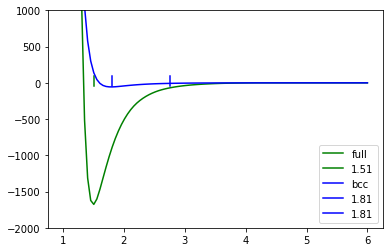

In [35]:
plt.plot(a_trace, both_energies[0], c='g', label='full')
plt.plot([latconsts[0], latconsts[0]], [-50, 100], c='g', label='{:.2f}'.format(latconsts[0]))
plt.plot(a_trace, both_energies[1], c='b', label='bcc')
plt.plot([latconsts[1], latconsts[1]], [-50, 100], c='b', label='{:.2f}'.format(latconsts[1]))
plt.plot([2.76, 2.76], [-50, 100], c='b', label='{:.2f}'.format(latconsts[1]))
plt.ylim([-2000, 1000])
plt.legend()

In [23]:
print(results1.x)
print(results2.x)

[  1.20795733 110.75024791]
[1.44574103 3.71864973]


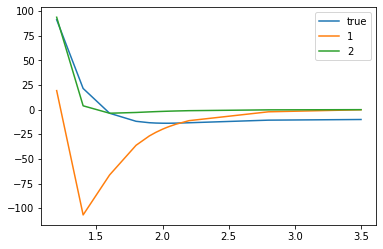

In [21]:
configs = dimers_only.configurations
latparams = np.array([np.linalg.norm(c.positions[1] - c.positions[0]) for c in configs])

calc_energies1 = np.array([lj1.get_potential_energy(atoms) for atoms in configs])
calc_energies2 = np.array([lj2.get_potential_energy(atoms) for atoms in configs])

true_energies = np.array([_['source-value'] for _ in dimers_only.get_data('energy')])

argsort = np.argsort(latparams)

plt.plot(latparams[argsort], true_energies[argsort], label='true')
plt.plot(latparams[argsort], calc_energies1[argsort], label='1')
plt.plot(latparams[argsort], calc_energies2[argsort], label='2')
plt.legend()

In [4]:
names = [
    'InP_JPCA2020',
    'Mo_PRM2019',
    'Nb_PRM2019',
    'Ta_Linear_JCP2015',
    'Ta_PRM2019',
    'V_PRM2019',
    'WBe_PRB2019',
    'W_PRB2019',
    'TiZrHfTa_APS2021',
    'CuPd_CMS2019',
    'CoNbV_CMS2019',
    'AlNiTi_CMS2019',
    'MoNbTaVW_PRB2021',
]

names = [
    'InP_JPCA2020',
    'MoNbTaVW_PRB2021',
    'Mo_PRM2019',
    'Nb_PRM2019',
    'Ta_Linear_JCP2015',
    'Ta_PRM2019',
    'V_PRM2019',
    'WBe_PRB2019',
    'W_PRB2019',
    'TiZrHfTa_APS2021',
    'CuPd_CMS2019',
    'CoNbV_CMS2019',
    'AlNiTi_CMS2019',
]

In [5]:
master = Dataset('master')

for i, name in enumerate(names):
    print('Attaching', name)

    master.merge(Dataset.from_markdown(
        f'/home/josh/colabfit/data/formatted/{name}/README.md',
        convert_units=True,
        verbose=True
    ))

/home/josh/colabfit-tools/core/dataset.py:996: UserWarning: No configurations were added to the default CS. "default" was removed from the regexes.
  warnings.warn(no_default_configs)


Attaching InP_JPCA2020


Parsing data: 100%|██████████| 1894/1894 [00:01<00:00, 1710.07it/s]


KeyboardInterrupt: 

In [ ]:
master.clean()

In [ ]:
master.resync(verbose=True)

In [ ]:
for c, cc in sorted(zip(master.co_labels, master.co_labels_counts), key=lambda x: x[1], reverse=True):
    print(c, cc)

In [ ]:
master.to_markdown(
    '/home/josh/colabfit/data/formatted/master',
    'README.md',
    'master.extxyz',
    'xyz',
    '_name',
)

In [3]:
len(ds1.data)

4023